# Sommaire

1. [Analyse du comportement des utilisateurs de l'application mobile](#description)
    * [Description du projet](#proj_description)
    * [But de travail](#purpose)
    * [Objectifs du projet](#tasks)
    * [Description des données](#data)
2. [Chargement des données et préparation à l'analyse](#open)
    * [Conclusion](#result)
3. [Analyse des entonnoirs](#funnel)
    * [Conclusion](#result_funnel)
4. [A/B Testing](#aab_test)
    * [Conclusion](#result_total)

# Analyse du comportement des utilisateurs de l'application mobile<a id="description"></a>

## Description du projet <a id="proj_description"></a>

Il y a une start-up qui vend des produits alimentaires. Il est nécessaire de comprendre comment les utilisateurs de l'application mobile se comportent. Pour cela, il est important d'analyser l'entonnoir de vente. Il faut savoir comment les utilisateurs parviennent à l'achat, combien d'utilisateurs parviennent à l'achat, et combien restent bloqués aux étapes précédentes, et lesquelles exactement.

Ensuite, il faut étudier les résultats du test A/B. Les designers proposent de changer la police de caractères dans toute l'application.

## But de travail  <a id="purpose"></a>


Analyser le comportement des utilisateurs de l'application mobile.

## Objectifs du projet  <a id="tasks"></a>

1) Étudier l'entonnoir des ventes.

2) Analyser les résultats du test A/B sur le changement de police.

## Description des données <a id="data"></a>

Les données sont présentées sous forme de journaux. Chaque entrée dans le journal est une action de l'utilisateur ou un événement.
- `EventName` — nom de l'événement;
- `DeviceIDHash` — identifiant unique de l'utilisateur;
- `EventTimestamp` — l'heure de l'événement;
- `ExpId` — le numéro de l'expérience : 246 et 247 sont les groupes de contrôle, tandis que 248 est le groupe expérimental.

# Chargement des données et préparation à l'analyse <a id="open"></a>

Chargeons les bibliothèques.

In [10]:
import pandas as pd
import datetime as dt
import numpy as np

from plotly import graph_objects as go
import plotly.express as px

import seaborn as sns
sns.set(style="white")
colors =["#D77FA1","#BAABDA","#D6E5FA","#FFF9F9"]
sns.set_palette(sns.color_palette(colors))

from matplotlib import pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters

from scipy import stats as st
import math as mth

In [2]:
sns.color_palette(colors)

[(0.8431372549019608, 0.4980392156862745, 0.6313725490196078),
 (0.7294117647058823, 0.6705882352941176, 0.8549019607843137),
 (0.8392156862745098, 0.8980392156862745, 0.9803921568627451),
 (1.0, 0.9764705882352941, 0.9764705882352941)]

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')
display(df.head())
print()
df.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
df.columns = ['event_name', 'user_id', 'event_datetime', 'group_id']

In [5]:
# nous découvrons le nombre d'événements uniques
df['event_name'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event_name, dtype: int64

In [6]:
# convertir les secondes en date et heure
df['event_datetime'] = pd.to_datetime(df['event_datetime'], unit='s')

# créons une colonne uniquement avec la date
df['date'] = df['event_datetime'].dt.strftime('%Y-%m-%d')
df.head()

,event_name,user_id,event_datetime,group_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [14]:
df.to_csv('out.csv', index=False)

In [15]:
print("Temps de début de l'expérience:", df['event_datetime'].min())
print("Temps de fin de l'expérience:", df['event_datetime'].max())

Temps de début de l'expérience: 2019-07-25 04:43:36
Temps de fin de l'expérience: 2019-08-07 21:15:17


In [16]:
# vérifions la présence de doublons
print(df.duplicated().sum())

# supprimons toutes les lignes en double
df = df.drop_duplicates()
df.info()

413
<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
event_name        243713 non-null object
user_id           243713 non-null int64
event_datetime    243713 non-null datetime64[ns]
group_id          243713 non-null int64
date              243713 non-null object
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [17]:
df['group_id'].value_counts()

248    85582
246    80181
247    77950
Name: group_id, dtype: int64

In [18]:
print("Nombre d'utilisateurs uniques:", df['user_id'].nunique())

Nombre d'utilisateurs uniques: 7551


In [19]:
print("Nombre moyen d'événements par utilisateur:", 
      int(df.groupby('user_id')['event_name'].count().mean()))

Nombre moyen d'événements par utilisateur: 32


In [20]:
!pip install -U seaborn

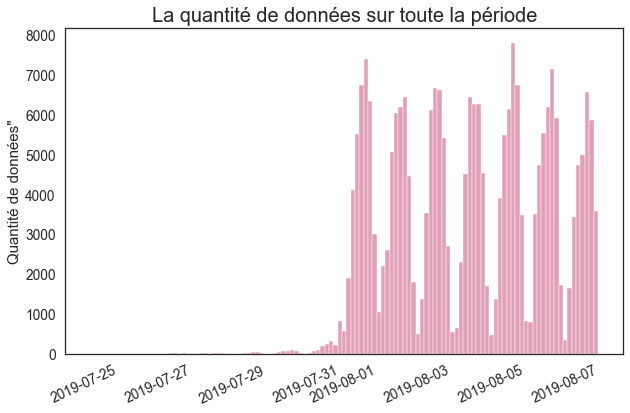

In [21]:
register_matplotlib_converters()

plt.figure(figsize=(10, 6)) 
sns.set_context("notebook", font_scale=1.25) #style du texte et taille des marques sur les axes

hist = sns.histplot(df['event_datetime'])
plt.xticks(rotation=25)
hist.set_title('La quantité de données sur toute la période', fontsize=20)
hist.set_ylabel('Quantité de données"') 
hist.set_xlabel("", fontsize=18); 


De l'histogramme, on peut voir que la quantité de données est répartie de manière inégale. En tenant compte de cela, nous allons effectuer une découpe par date.

In [22]:
df_slice = df.query('event_datetime >= "2019-07-31 21:00:00"')

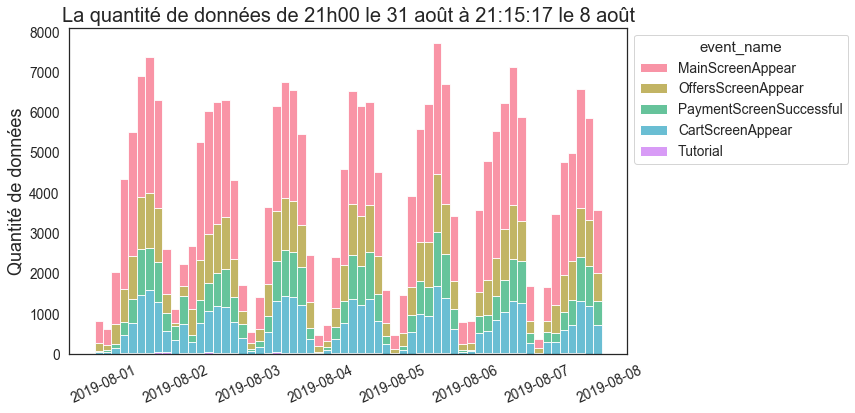

In [23]:
plt.figure(figsize=(10, 6))
sns.set_context("notebook", font_scale=1.25)

hist_date = sns.histplot(data = df_slice,
                         x='event_datetime', 
                         hue= 'event_name', 
                         multiple="stack")
plt.xticks(rotation=25)
hist_date.set_title('La quantité de données de 21h00 le 31 août à 21:15:17 le 8 août', fontsize=20) 
hist_date.set_ylabel('Quantité de données', fontsize=18)  
hist_date.set_xlabel("", fontsize=18) 
sns.move_legend(hist_date, "upper left", bbox_to_anchor=(1, 1)); 

Nous allons déterminer combien d'événements et d'utilisateurs nous avons perdus en éliminant les données.

In [24]:
print("Pourcentage d'événements conservés après la suppression des données :",
      round(df_slice["event_name"].count()/df['event_name'].count()*100, 2), "%")

Pourcentage d'événements conservés après la suppression des données : 99.18 %


In [25]:
print("Pourcentage d'utilisateurs uniques conservés après la suppression des données :",
      round(df_slice['user_id'].nunique()/df['user_id'].nunique()*100, 2), "%")

Pourcentage d'utilisateurs uniques conservés après la suppression des données : 99.83 %


In [26]:
df_slice['group_id'].value_counts()

248    84875
246    79556
247    77293
Name: group_id, dtype: int64

## Conclusion <a id="result"></a>


- Après avoir examiné les données, 5 événements ont été identifiés, répartis en 3 groupes expérimentaux, avec un total de 7551 utilisateurs uniques.
- Le nombre moyen d'événements par utilisateur est de 32.
- L'expérience a été menée du 25 juillet 2019 à 04h43m36s au 7 août 2019 à 21h15m17s.
- Les doublons ont été détectés et supprimés des données, et les colonnes ont été renommées.
- Le type de données de la colonne "event_date" a été converti en type temporel, et une nouvelle colonne "date" a été créée.
- En se basant sur l'histogramme de la distribution temporelle des données, il a été décidé de faire une sélection des données de 2019-07-31 21:00:00 à 2019-08-07 21:15:17, car c'était la période où le nombre d'événements était uniforme.
- Il a été constaté que ce nouveau jeu de données représente entre 99 et 99,5 % du nombre initial de données, en fonction de l'événement.
- Le nombre d'utilisateurs uniques représente 99,7 % du nombre initial.
- Le nombre d'événements représente 99,18 % des données initiales. Ainsi, les pertes peuvent être considérées comme négligeables, car elles sont inférieures à 1 %.

# Analyse des entonnoirs <a id="funnel"></a>

**1. Examinons les événements présents dans les journaux, à quelle fréquence ils se produisent. Trierons les événements par fréquence.**

In [ ]:
df_slice.head()


In [ ]:
event_number = df_slice\
    .groupby("event_name", as_index=False)\
    .agg({"event_datetime":"count"})\
    .rename(columns={"event_datetime":"n_events"})

event_number.sort_values(by="n_events", ascending=False)

In [ ]:
# excluons le Tutorial de la liste des événements
event_number_x = event_number.query('event_name != "Tutorial"')
event_number_x

In [ ]:
fig = go.Figure(
    go.Funnel(
    y = event_number_x["event_name"],
    x = event_number_x['n_events']
    )
)
# ajoutons le titre du graphique au centre
fig.update_layout(title_text="Nombre de vues/affichages d'événements", 
                  height=500,
                  title_x=0.5)
fig.show()

- L'événement le plus fréquent est l'apparition de l'écran principal (MainScreenAppear). Cela s'est produit 117 889 fois.
- Le deuxième événement le plus fréquent est l'apparition de l'écran du catalogue des produits (OffersScreenAppear). Cela s'est produit 46 531 fois.
- Le troisième événement est l'apparition de l'écran du panier (CartScreenAppear). Cela s'est produit 42 343 fois.
- Le quatrième événement est l'apparition de l'écran de paiement réussi (PaymentScreenSuccessful). Cela s'est produit 33 951 fois.

**2. Découvrons combien d'utilisateurs ont effectué chacun de ces événements. Nous trierons les événements par le nombre d'utilisateurs. Ensuite, nous calculerons la part d'utilisateurs qui ont effectué l'événement au moins une fois.**

In [ ]:
# сréons un tableau avec le nombre d'actions et le nombre d'utilisateurs uniques pour chaque événement
events = (
    df_slice.groupby('event_name')['user_id']
    .agg(['count', 'nunique'])
    .reset_index()
    .sort_values(by='nunique', ascending=False)
)
events.columns = ['event_name', 'n_events', 'n_users']
events

In [ ]:
names = events.sort_values('n_events', ascending=False).reset_index(drop=True)['event_name']
names

In [ ]:
# nombre total d'utilisateurs uniques
users_all = df_slice['user_id'].nunique()
users_all

In [ ]:
# la proportion d'utilisateurs ayant effectué au moins une fois des actions
events['part'] = (events['n_users'] / users_all * 100).round(1)
events

In [ ]:
plt.figure(figsize=(14, 7))
ax_part = sns.barplot(y=['Écran principal', 'Écran des offres', 'Panier', 
                         'Écran de paiement réussi', 'Tutoriel'],
                      x='part', 
                      data=events, 
                      palette="Spectral")

for p in ax_part.patches:
    ax_part.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(3, 0), textcoords='offset points', ha="left", va="center")
    
        
ax_part.set_title("La proportion d'utilisateurs ayant visité l'écran au moins une fois", fontsize=20)
ax_part.set_ylabel('')
ax_part.set_xlabel("La proportion d'utilisateurs, %", fontsize=18);

In [ ]:
events1 = events.query('event_name != "Tutorial"')
events1

In [ ]:
fig_1 = go.Figure(
    go.Funnel(
    y = ['Écran principal ', 'Écran des offres ', 'Panier ', 'Écran de paiement réussi '],
    x = events1['n_users']
    )
)

# ajoutons le titre du graphique au centre
fig_1.update_layout(title_text="Nombre d'utilisateurs ayant visité l'écran", 
                  height=500,
                  title_x=0.5)
fig_1.show()

Du graphique, on peut déduire:

- 7243 utilisateurs ont ouvert l'écran principal (98,5 % par rapport au nombre total d'utilisateurs);
- 4597 utilisateurs ont consulté la page du catalogue des offres (61 %);
- 3736 utilisateurs ont ouvert le panier (49,6 %);
- 3540 utilisateurs ont vu la page de "paiement réussi" (47 %).

Probablement, les événements se déroulent dans l'ordre suivant : "Écran principal" => "Écran des offres" => "Panier" => "Paiement réussi".


"Tutorial" peut probablement être consulté à n'importe quelle étape après avoir consulté "l'écran principal". C'est pourquoi nous l'avons exclu du tunnel.

## Conclusion <a id="result_funnel"></a>

À partir de l'analyse de l'entonnoir d'événements, les conclusions suivantes ont été tirées :

- L'événement le plus fréquent est l'apparition de l'écran principal (MainScreenAppear). Il s'est produit 117 889 fois ;
- Près de 40% des utilisateurs n'avancent pas au-delà de la consultation de l'écran principal. Il est probablement nécessaire de mieux travailler sur la mécanique de l'écran principal afin que les utilisateurs accèdent à l'écran des offres;
- Seulement 11,2% du nombre total d'utilisateurs ont consulté l'écran "Tutorial".

# A/B Testing <a id="aab_test"></a>

Nous déterminerons le nombre d'utilisateurs dans chaque groupe expérimental.

246 et 247 sont les groupes de contrôle, tandis que 248 est le groupe expérimental.

**1. Vérifions la différence statistique entre le groupe 246 et le groupe 247.**

In [ ]:
# le nombre d'utilisateurs uniques dans chaque groupe"
group_count_users = df_slice.groupby('group_id', as_index=False).agg({'user_id':'nunique'})
group_count_users

In [ ]:
event_pivot = (df_slice
               .groupby(['event_name','group_id'], as_index=False)
               .agg({'user_id': ['count', 'nunique']})
)

event_pivot.columns = ['event_name','group_id', 'n_events', 'n_users']
event_pivot

In [ ]:
event_pivot_246 = event_pivot.query('group_id == "246"')
event_pivot_247 = event_pivot.query('group_id == "247"')
event_pivot_248 = event_pivot.query('group_id == "248"')
all_pivot_group = [event_pivot_246, event_pivot_247, event_pivot_248]

In [ ]:
for i in event_pivot_246['n_users']:
        event_pivot_246['part'] = (event_pivot_246['n_users'] / 2484 * 100).round(1)
print(event_pivot_246)
print('')

for i in event_pivot_247['n_users']:
        event_pivot_247['part'] = (event_pivot_247['n_users'] / 2517 * 100).round(1)
print(event_pivot_247)
print('')

for i in event_pivot_248['n_users']:
        event_pivot_248['part'] = (event_pivot_248['n_users'] / 2537 * 100).round(1)
print(event_pivot_248)
print('')

In [ ]:
event_pivot_group_control = event_pivot_246.append(event_pivot_247)
event_pivot_all = event_pivot_group_control.append(event_pivot_248)
event_pivot_all

Nous allons vérifier l'hypothèse suivante :

H0 : Il n'y a pas de différence entre les proportions des groupes 246 et 247.

H1 : Il y a des différences entre les proportions des deux groupes.

In [ ]:
groups = [246, 247, 248]

# создадим список события для всех кроме руководства
no_tutorial = (events[events['event_name'] != 'Tutorial']
         .sort_values('n_events', ascending=False)['event_name']
         .reset_index(drop=True))
no_tutorial

In [ ]:
events['event_name']

In [ ]:
n_users_group = {'all': df_slice['user_id'].nunique(), 
           246: df_slice[df_slice['group_id']==246]['user_id'].nunique(),
           247: df_slice[df_slice['group_id']==247]['user_id'].nunique(),
           248: df_slice[df_slice['group_id']==248]['user_id'].nunique(),
           '246+247': df_slice[(df_slice['group_id']==246) | (df_slice['group_id']==247)]['user_id'].nunique()}
n_users_group

In [ ]:
# créons un tableau avec le nombre d'utilisateurs uniques dans chaque groupe pour chaque événement
n_users_by_event = {}
for group in groups:
    n_users_by_event[group] =[]
    for event in no_tutorial:
        n_users_by_event[group].append(df_slice[(df_slice['group_id'] == group) & 
                                             (df_slice['event_name'] == event)]['user_id'].nunique())
n_users_by_event = pd.DataFrame(n_users_by_event)
n_users_by_event['246+247'] = n_users_by_event[246] + n_users_by_event[247]
n_users_by_event['event_name'] = no_tutorial
n_users_by_event

In [ ]:
# la fonction de test Z pour comparer chaque paire de groupes
def z_test(first_group, second_group, alpha):
    for i in n_users_by_event.index:
        #alpha = alpha
        p1 = n_users_by_event[first_group][i] / n_users_group[first_group]
        # le taux de succès dans le deuxième groupe:
        p2 = n_users_by_event[second_group][i] / n_users_group[second_group]
        # le taux de succès dans 2 groups combiné:
        p_combined = ((n_users_by_event[first_group][i] + n_users_by_event[second_group][i]) / 
                      (n_users_group[first_group] + n_users_group[second_group]))
        
        # différence de proportions
        difference = p1 - p2
        
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * \
                                        (1/n_users_group[first_group] + 1/n_users_group[second_group]))
        
        # définissons une distribution normale standard (moyenne 0, écart-type 1).
        distr = st.norm(0, 1) 
        p_value = round((1 - distr.cdf(abs(z_value))) * 2, 2)
        print('{} Valeur p: {}'.format(n_users_by_event['event_name'][i], p_value))
        if (p_value < alpha):
            print("Nous rejetons l'hypothèse nulle : il y a une différence significative entre les proportions")
        else:
            print("Nous n'avons pas pu rejeter l'hypothèse nulle")
            print("Il n'y a pas de raison de considérer les proportions comme différentes.")
        print('')

Pour réduire la probabilité de faux positifs lors de tests multiples d'hypothèses, nous pouvons appliquer la méthode de correction du niveau de signification pour réduire le FWER (Erreur de première espèce globale) - l'ajustement de Bonferroni.

In [ ]:
alpha = 0.1

In [ ]:
alpha_bonff = alpha / 20
alpha_bonff

In [ ]:
z_test(246, 247 , alpha_bonff)


Pour aucun des événements, la différence n'était significative. Par conséquent, la division en groupes était correcte.

In [ ]:
# Vérifions l'hypothèse avec un niveau de signification de 0,1
z_test(246, 247 , alpha)


En utilisant un niveau de signification plus élevé, la division est également considérée comme correcte.

In [ ]:
event_pivot_group_control = event_pivot_group_control.sort_values(by='n_events', ascending=False)
event_pivot_group_control

In [ ]:
plt.figure(figsize=(14, 7))
bx_part = sns.barplot(y= 'event_name',
                      x='part', 
                      hue='group_id',
                      data=event_pivot_group_control)
for p in bx_part.patches:
    bx_part.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(1, 0), textcoords='offset points', ha="left", va="center")
    
        
bx_part.set_title("Le pourcentage d'utilisateurs du groupe ayant effectué l'événement", fontsize=20)
bx_part.set_ylabel('')
bx_part.set_xlabel("Part du nombre total d'utilisateurs, %", fontsize = 18);

**2. Vérifions la différence statistique entre le groupe 246 et le groupe 248**


Nous allons vérifier l'hypothèse suivante :

H0 : Il n'y a pas de différence entre les proportions des groupes 246 et 248.

N1 : Il y a des différences entre les proportions des deux groupes.

In [ ]:
z_test(246, 248 , alpha_bonff)


Pour aucun des événements, la différence n'était significative. Par conséquent, les proportions du groupe 246 et du groupe 248 ne sont pas statistiquement différentes.

In [ ]:
# Vérifions l'hypothèse avec un niveau de signification de 0,1
z_test(246, 248 , alpha)


Nous constatons qu'il existe une différence statistiquement significative entre les groupes pour l'événement "Ajout au panier". Par conséquent, il est préférable d'utiliser notre niveau de signification initial.

**3. Vérifions la différence statistique entre le groupe 247 et le groupe 248**

Nous allons vérifier l'hypothèse suivante :

H0 : Il n'y a pas de différence entre les proportions des groupes 247 et 248.

N1 : Il y a des différences entre les proportions des deux groupes.

In [ ]:
z_test(247, 248 , alpha_bonff)


Pour aucun des événements, la différence n'était significative. Par conséquent, les proportions du groupe 247 et du groupe 248 ne sont pas statistiquement différentes.

In [ ]:
# Vérifions l'hypothèse avec un niveau de signification de 0,1
z_test(247, 248 , alpha)


En utilisant un niveau de signification plus élevé, la division est également considérée comme correcte.

**4. Vérifions la différence statistique entre le groupe combiné 246 et 247 avec le groupe 248.**


Nous allons vérifier l'hypothèse suivante :

H0 : Il n'y a pas de différence entre les proportions des groupes 246 + 247 et 248.

N1 : Il y a des différences entre les proportions des deux groupes.

In [ ]:
z_test('246+247', 248 , alpha_bonff)

Le groupe de contrôle combiné n'a également montré aucune différence significative par rapport au groupe expérimental 248. Au total, 20 tests d'hypothèses statistiques ont été effectués.

In [ ]:
# Vérifions l'hypothèse avec un niveau de signification de 0,1
z_test('246+247', 248 , alpha)


En utilisant un niveau de signification plus élevé, la division est également considérée comme correcte.

## Conclusion <a id="result_total"></a>

Ce projet comprend 5 événements/pages dans l'application auxquels les utilisateurs ont accédé du 25 juillet 2019 à 04:43:36 au 7 août 2019 à 21:15:17. Tous les utilisateurs ont été répartis en 3 groupes : 2 groupes de contrôle et 1 groupe expérimental. L'idée de l'expérience était de déterminer si la nouvelle police de caractères proposée par les designers dissuaderait les utilisateurs.

Tout d'abord, une préparation des données pour l'analyse a été réalisée : changement du type de données et renommage des colonnes.

En construisant un histogramme par date et heure, la décision a été prise de ne conserver que les données de 2019-07-31 21:00:00 à 2019-08-07 21:15:17, car elles reflètent des résultats uniformes de l'étude. Le nouveau jeu de données contient plus de 99 % du nombre initial de données.

Ensuite, un entonnoir d'événements a été construit, révélant que :

- L'événement le plus fréquent est l'apparition de l'écran principal (MainScreenAppear). Il s'est produit 117 889 fois ;
- Près de 40% des utilisateurs n'avancent pas au-delà de la consultation de l'écran principal. Il est probablement nécessaire de mieux travailler sur la mécanique de l'écran principal afin que les utilisateurs accèdent à l'écran des offres;
- Seulement 11,2% du nombre total d'utilisateurs ont consulté l'écran "Tutorial".

La partie finale de l'étude a impliqué l'analyse d'un A/B-testing. 
Au total, 20 tests d'hypothèses statistiques ont été effectués avec un niveau de signification alpha basé sur la correction de Bonferroni, soit 0,005. Les hypothèses ont été testées pour chaque événement, c'est-à-dire chaque page de l'application. Toutes les hypothèses ont montré qu'il n'y avait aucune différence significative entre les groupes de contrôle ou entre les groupes de contrôle et le groupe expérimental. Cela indique que le modification de police n'a apporté aucune changement sur le comportement des utilisateurs. 
Les utilisateurs passent d'une page à l'autre dans la même proportion. Cela signifie que changer la police de caractères n'entraînera pas une plus grande quantité d'utilisateurs à effectuer un achat. Par conséquent, le problème de la perte d'utilisateurs doit être recherché ailleurs.